In [27]:
##################################################################################################################
##*********              Moukouba Moutoumounkata, February 21st 2020       ***************                      ##
##                          Hourly Bike Sharing Demand Prediction                                               ##
## Note: Most of the code was written following the sklearn and other python documentations                     ##
##################################################################################################################



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar as cal
import pdpipe as pdp

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR


%matplotlib inline

data = pd.read_csv("/home/moukouba/MEGA/DATA_MINING/FAVOURITE/ML/CHALLENGE/Bike-Sharing-Dataset/hour.csv")

**Task:**
<div style="text-align: justify">
Forecasting the hourly bike rental demand of the Bike sharing program in Washington, D.C. based on historical usage patterns in relation with weather, time and other data.
</div>

In [28]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Data Characteristics:**

<div style="text-align: justify"> 
The data set "hour.csv" consists of 17 columns detailed bellow:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not 
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered.

Note the inconsistency of the "season" column. The data was collected from Whashington D.C., which lies in the northern hemisphere. That is, January 1st does not correspond to Spring, but corresponds to Winter.
</div>

**Hypotheses:**
<div style="text-align: justify"> 
1 - Bike usage will be subject to weather and climate situations;
   
2 - It will vary depending on the period of the day (morning, afternoon, evening, night);
    
3 - It will also vary depending on the period of the year (seasons).
</div>

In [29]:
#Checking for missing values
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

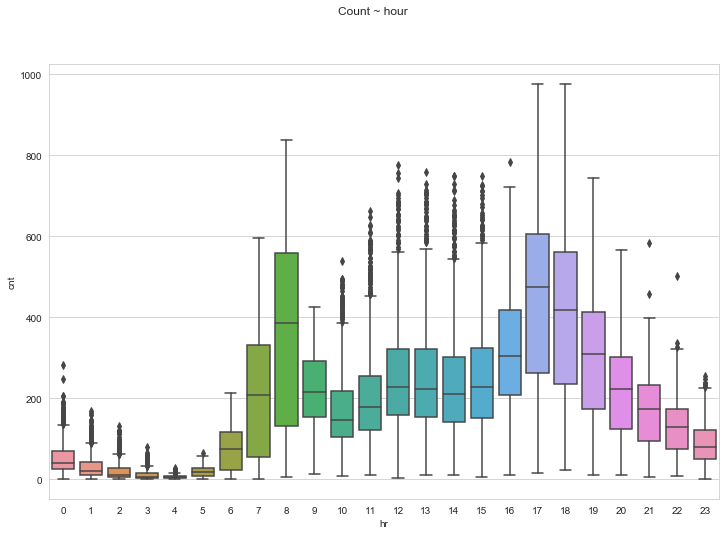

In [30]:
#plotting the total count of users vs hour
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Count ~ hour', fontsize=12)
sns.boxplot(x="hr", y="cnt", data=data)
plt.show()

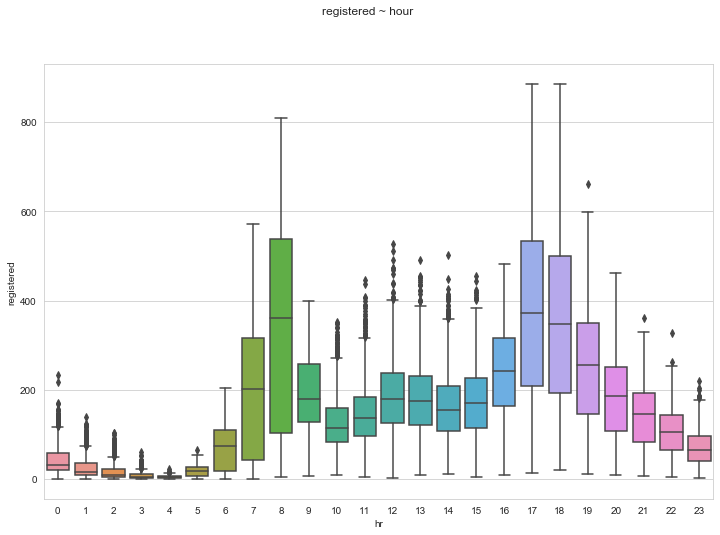

In [6]:
#plotting the count of registered users vs hour
fig = plt.figure(figsize=(12, 8))
fig.suptitle('registered ~ hour', fontsize=12)
sns.boxplot(x="hr", y="registered", data=data)
plt.show()

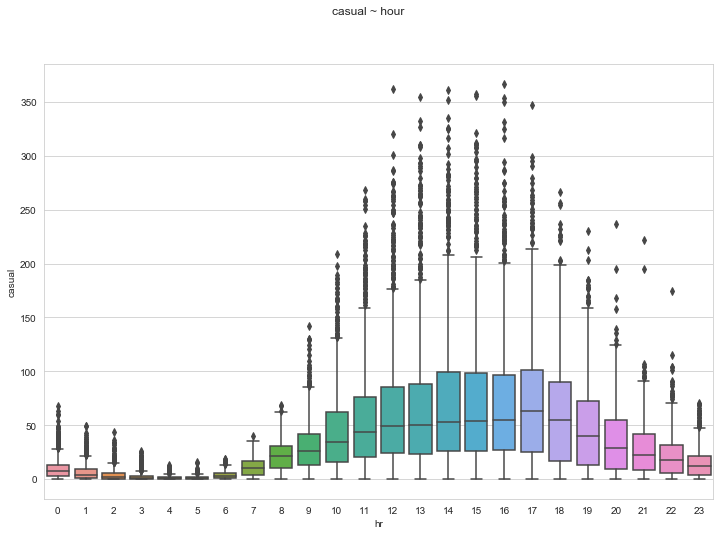

In [7]:
#plotting the count of casual users vs hour
fig = plt.figure(figsize=(12, 8))
fig.suptitle('casual ~ hour', fontsize=12)
sns.boxplot(x="hr", y="casual", data=data)
plt.show()

**Note:**
<div style="text-align: justify"> 
From the three figures above, it can be seen that the total count, "cnt", and "registered" have similar trends, whereas "casual" has a very different trend. While data is heavily affected by outliers, one can note that the bulk of outliers is brought in by "casual users". One can consider these as natural (true) outliers, since they are not due to measurement errors.

We can see on both, "registered" and "cnt", that we have two peaks in the demand, viz., the first occurring between 7 a.m and 8 a.m, and the second between 4 p.m and 7 p.m. This is consistent with the daily rush hours as related to human activities (going to work in the morning, at work between morning and early evening, and going back home in the evening)... 
</div>

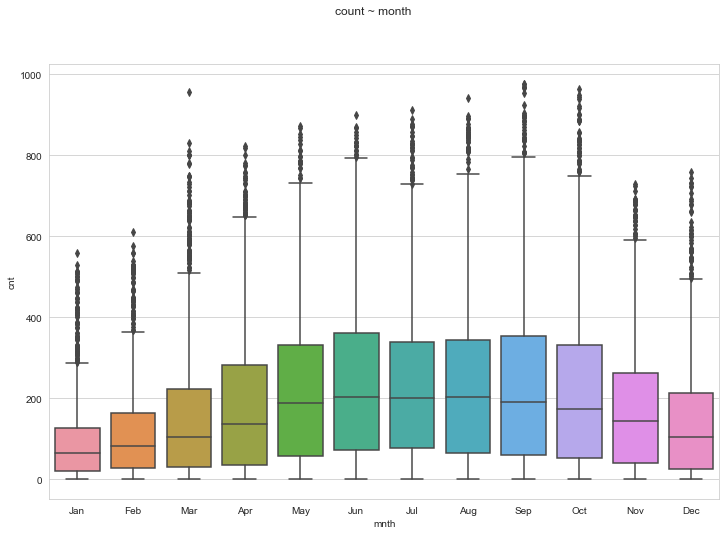

In [8]:
#replacing month number by its literal name, and plotting count vs month
months = list(cal.month_abbr)
mnth_dict = {i : months[i] for i in range(0, len(months))}
data["mnth"] = data["mnth"].map(mnth_dict)

fig = plt.figure(figsize=(12, 8))
fig.suptitle('count ~ month', fontsize=12)
sns.boxplot(x="mnth", y="cnt", data=data)
plt.show()

In [9]:
#Derive a season column based on "dteday" column and replace the original for inconsistency
days = list(cal.day_abbr)
weekdays = {i : days[i] for i in range(0, len(days))}
data["weekday"] = data["weekday"].map(weekdays)

data["dteday"] = data["dteday"].apply(pd.to_datetime, errors="coerce")
bins = [0, 91, 183, 275, 366]
labels=["Winter", "Spring", "Summer", "Fall"]
doy = data["dteday"].dt.dayofyear
data["season"] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels).astype(str)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,Winter,0,Jan,0,0,Sun,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,Winter,0,Jan,1,0,Sun,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,Winter,0,Jan,2,0,Sun,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,Winter,0,Jan,3,0,Sun,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,Winter,0,Jan,4,0,Sun,0,1,0.24,0.2879,0.75,0.0,0,1,1


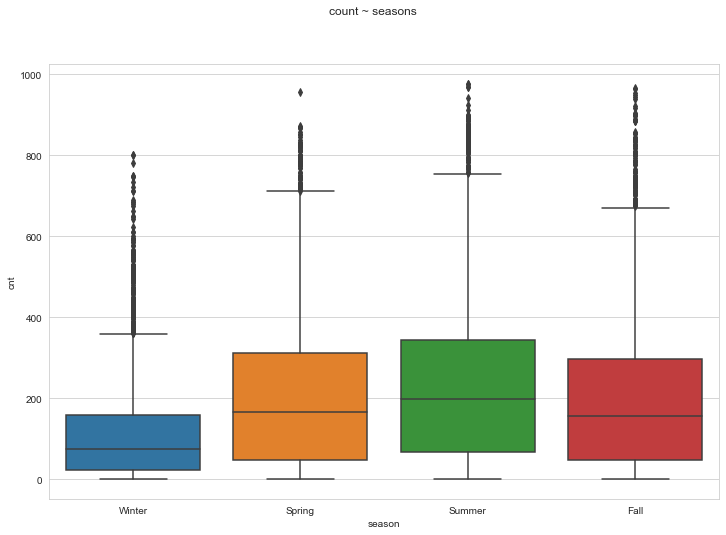

In [10]:
#Plotting count vs season
fig = plt.figure(figsize=(12, 8))
fig.suptitle('count ~ seasons', fontsize=12)
sns.boxplot(x="season", y="cnt", data=data)
plt.show()

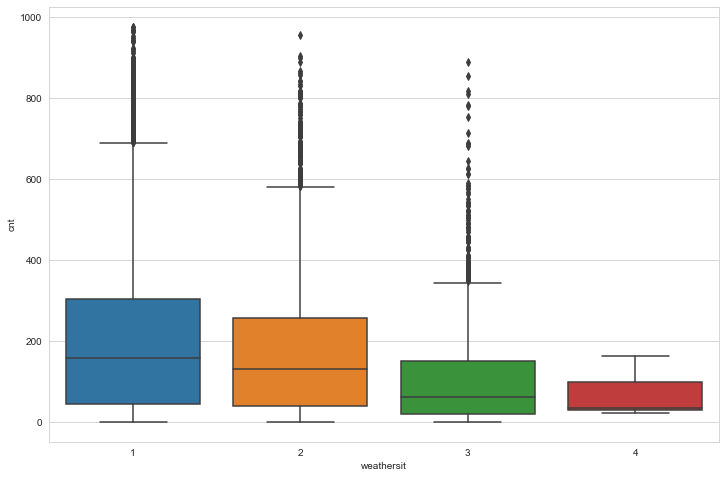

In [11]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="weathersit", y="cnt", data=data)
plt.show()

**Note:**
<div style="text-align: justify"> 
From the two graphics above, we can see that the activity is very low in winter, and starts rising in spring up to reaching a peak in Summer, and starts tapering off in Fall. This is very consistent with the hypothesis that, one is more likely to use a bike during warmer seasons than in cold ones. Also, the more severe the weather (weathersit = 3 & 4), the least likely is it for one to ride a bike. That is, climate and weather situation have an influence on the likelihood of one willing to ride a bike or not.
</div>

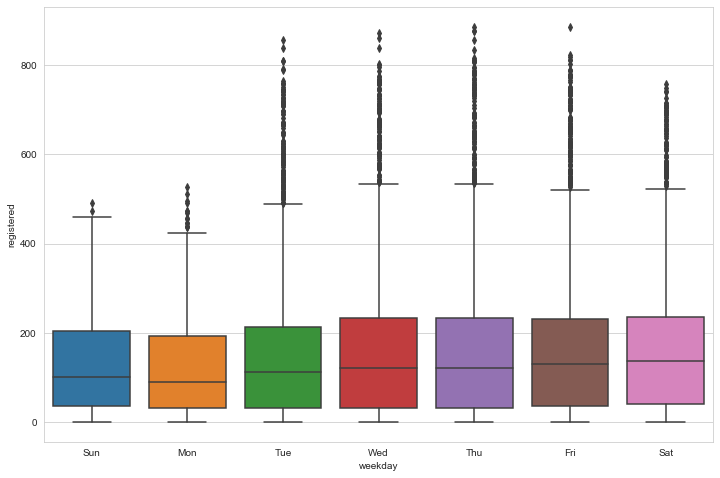

In [12]:
#plot of registered users count vs weekday
plt.figure(figsize=(12, 8))
sns.boxplot(x="weekday", y="registered", data=data)
plt.show()

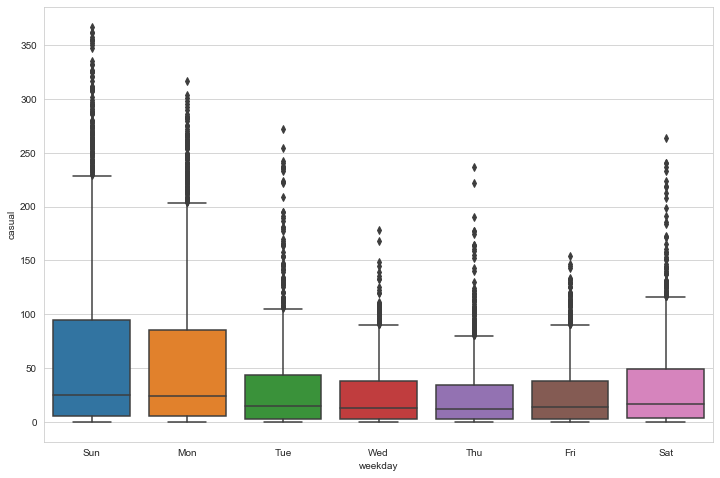

In [13]:
#plot of casual users count vs weekday
plt.figure(figsize=(12, 8))
sns.boxplot(x="weekday", y="casual", data=data)
plt.show()

**Note:**
<div style="text-align: justify">
Looking at the two plots above, it can be seen that count of registered users increase during busines days (Monday to Friday), while the count of casual users is high during the weekends.
</div>

In [14]:
#Correlation table of numerical variables
df = data.iloc[:,10:]
df.corr()
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(corr_mat, annot=True, linewidths=.5, ax=ax)

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234
casual,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.694564
registered,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.972151
cnt,0.404772,0.400929,-0.322911,0.093234,0.694564,0.972151,1.000000


**Note:**
<div style="text-align: justify"> 
The correlation table shows that Temperature and Humidity are the most highly correlated numerical variables to the count; and the sensible temperature (atemp) is highly correlated to the measured temperature (temp). That means that keeping both attributes could induce multicolinearity. But, after trials, it has been noticed that keeping or removing "atemp" does not impair that much on the performance of the model. 
    
Also, it is worthy of note that the table above is based on Pearson's correlation, which is a linear measure, and as such, is not appropriate to measure non-linear relationship, should there be one. 
</div>

<div style="text-align: justify"> 
As we can see, the count column heavily suffers from outliers, which is also revealed by the skewness of the density curve bellow. To limit the distortion brought by outliers, we'll use a log-transformation and thus, predict log(cnt) in place of "cnt". An inverse transformation will make it possible to reconstruct, when needed,  the original cnt. Note that, the Scipy "boxcox" method will be used, setting  lambda to zero; as the Box-Cox tends to log as lambda tends to 0.
</div>

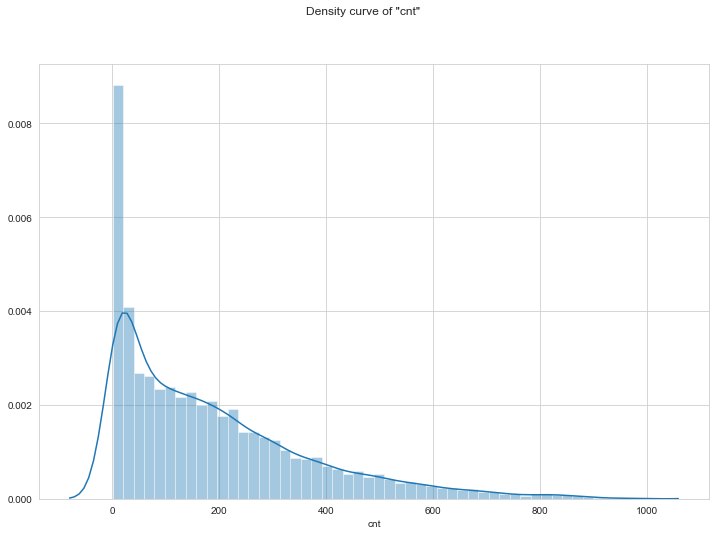

In [32]:
#Plotting the Kernel Density Estimation curve of cnt
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Density curve of "cnt"', fontsize=12)
sns.distplot(data["cnt"])

In [35]:
#Box-Cox transforming the "cnt" for outlier treatment
#General setting, where scipy finds the best lambda "data["cnt"], fitted_lmbda = boxcox(data["cnt"])"
#lmbda set to "0" corresponds to the log-transformation.
data["cnt"] = boxcox(data["cnt"], lmbda=0)

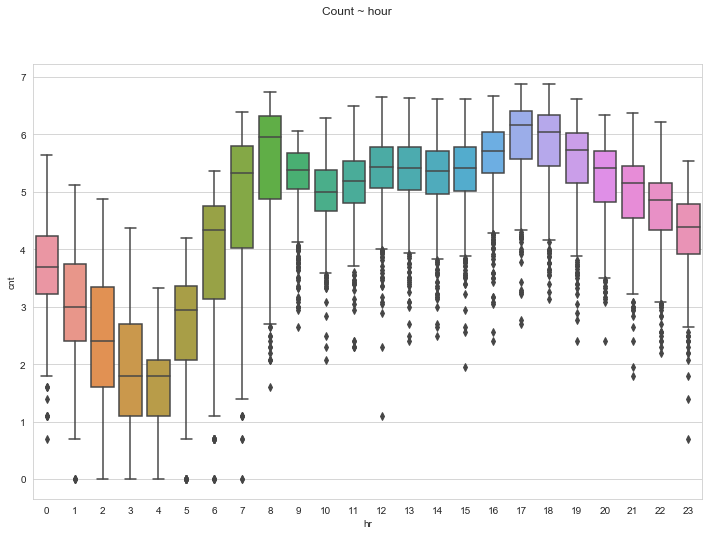

In [36]:
#plotting the log of count of users vs hour 
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Count ~ hour', fontsize=12)
sns.boxplot(x="hr", y="cnt", data=data)
plt.show()

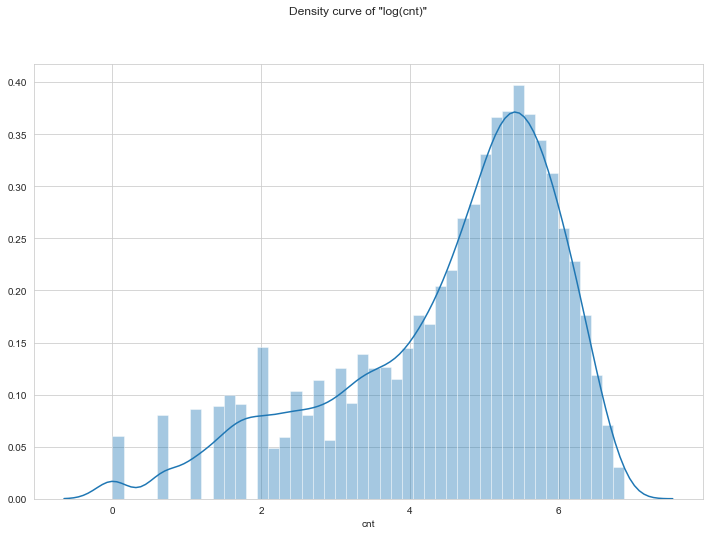

In [37]:
#Plotting the Kernel Density Estimation curve of log(cnt)
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Density curve of "log(cnt)"', fontsize=12)
sns.distplot(data["cnt"])

<div style="text-align: justify"> 
We can see that the log-transformation has significantly smoothed the data, by compressing the outliers, forcing the distribution of the data to  conform as closely as possible to a normal distribution.
</div>

In [21]:
#Defining two variables X and y storing the features and the target variable respectively
X, y = data.iloc[:,:-1], data["cnt"]

#pdp.OneHotEncode() is equivalent to pandas get_dummies(..., drop_first=True) 
preprocessor = pdp.PdPipeline([
                                pdp.ColDrop(["instant","dteday", "yr", "casual", "registered"]), 
                                pdp.OneHotEncode(["season", "mnth", "hr", "weekday", "weathersit"])])

X = preprocessor(X)
X.head()

,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,season_Winter,mnth_Aug,...,hr_23,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0.22,0.2727,0.80,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0.22,0.2727,0.80,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0.24,0.2879,0.75,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0.24,0.2879,0.75,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


**Note:**

<div style="text-align: justify"> 
A set of columns was dropped as these do not have a predictive importance for some ("instant","dteday", "yr"), or are just constituents of the target variable for others ("casual", "registered").

Categorical variables (viz. "season", "mnth", "hr", "weekday", "weathersit") where one-hot-encoded (a process also called "variable dummification), before being used in the models.
    
Further pre-processing (like binning "hour") would have been done, and that could potentially  improve the prediction power of models, but this was not done as the exersise consits in predicting the "hourly" count but not the count over a certain time range, say 3 or 4 hours. 
</div>

**Modeling:**
<div style="text-align: justify"> 
In this step, a best model will be automatically selected from a bench of candidate models. Pipelining is an efficient way for code reusability. The process bellow is done in such a manner that it can be used for both regression and classification once proper data pre-processing has been done; suffice it to replace the term "regressor", wherever it appears, with the term "classifier".
    
For hyper-parameters tuning, a randomized search was preferred to the grid search, for its better performance, and was carried out on each candidate model to select only the best one and make predictions.
</div>

In [22]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [109]:
#Random Forest and Extra Trees hyperparameter random grid
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ["auto", "sqrt", "log2"]
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create a pipeline
pipe = Pipeline([("regressor", ExtraTreesRegressor())])
# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [
                {"regressor": [ExtraTreesRegressor()],
                               "regressor__n_estimators": n_estimators,
                               "regressor__max_features": max_features,
                               "regressor__max_depth": max_depth,
                               "regressor__min_samples_split": min_samples_split,
                               "regressor__min_samples_leaf": min_samples_leaf
                              
                },
                {"regressor": [RandomForestRegressor()],
                                "regressor__n_estimators": n_estimators,
                               "regressor__max_features": max_features,
                               "regressor__max_depth": max_depth,
                               "regressor__min_samples_split": min_samples_split,
                               "regressor__min_samples_leaf": min_samples_leaf
                               
                },
                {"regressor": [GradientBoostingRegressor()],
                               "regressor__learning_rate": sp_randFloat(),
                               "regressor__subsample": sp_randFloat(),
                               "regressor__n_estimators": n_estimators,
                               "regressor__max_depth": max_depth
                               
                },
                {"regressor": [LGBMRegressor()],
                               "regressor__n_estimators": n_estimators,
                               "regressor__num_leaves" : sp_randInt(6, 50),
                               "regressor__min_child_samples" : sp_randInt(100, 500),
                               "regressor__subsample" : sp_randFloat(loc=0.2, scale=0.8),
                               "regressor__colsample_bytree" : sp_randFloat(loc=0.4, scale=0.6),
                               "regressor__reg_alpha" : [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                               "regressor__reg_lambda" : [0, 1e-1, 1, 5, 10, 20, 50, 100],
                               "regressor__min_child_weight" : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
                },
                {"regressor": [SVR()],
                               "regressor__C": sp_randFloat(2, 20), 
                               "regressor__gamma": sp_randFloat(0.1, 1)
                              
                }]

# create a randomized search of the pipeline, and fit the best model
rand_search = RandomizedSearchCV(pipe, search_space, n_iter = 20,
                                 cv = 10, verbose=2, random_state=42, 
                                 n_jobs=-1)

best_model = rand_search.fit(X_train, y_train) 
#print(best_model.cv_results_)
print(best_model.best_estimator_)

y_pred = best_model.predict(X_test)
score1 = best_model.score(X_train, y_train)
score2 = best_model.score(X_test, y_test)

print("The score on training and test sets are %.2f and %.2f, respectively."%(score1, score2))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.5min
/home/moukouba/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 23.1min finished


Pipeline(memory=None,
         steps=[('regressor',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.6971061460667621,
                               importance_type='split', learning_rate=0.1,
                               max_depth=-1, min_child_samples=134,
                               min_child_weight=1e-05, min_split_gain=0.0,
                               n_estimators=400, n_jobs=-1, num_leaves=45,
                               objective=None, random_state=None, reg_alpha=2,
                               reg_lambda=0.1, silent=True,
                               subsample=0.5401246995929958,
                               subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)
The score on training and test sets are 0.94 and 0.91, respectively.


In [110]:
#Mean Absolute Error on the test set
mean_absolute_error(y_test, y_pred)

0.3282172058479097

In [116]:
#Reconstructed y_pred & y_test with lambda = 0, i.e., inverse log-transformation
#rec_pred = inv_boxcox(y_pred, 0)
#rec_test = inv_boxcox(y_test, 0)

**Note:**
<div style="text-align: justify"> 
The LGBMRegressor has had the best performance out of 5 models. After having run the models under different data conditions (keeping the target variable unchanged, capping the outliers with 90th percentile, Box-Cox transforming or log-transforming, ...) it has been imposible to significantly improve the scores of the models beyond the values bellow. It has also been noticed that the log-transformation was more appropriate, as it yielded better scores on both, train and test sets. 
    
The best scores achieved are: a coefficient of determination (R-squared) of <span style="font-weight:bold">0.94</span> and <span style="font-weight:bold">0.91</span> on the train and test sets respectively; and a Mean Absolute Error (MAE) of <span style="font-weight:bold">~0.33</span> on the test set. There are still possible tweakings that could potentially improve these scores; for instance, futher feature engineering, by binning say, the "hour" column or, maybe, by reducing the dimensionality. Otherwise, considering that cnt = registered + casual, and that the distributions of casual and registered are very divergent, with casual users accounting for the bulk of outliers, one could think of separately predicting the two (casual and registered), and adding up the final results to obtain the predicted value of cnt. 
</div>